In [1]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
import copy
import mne

##### construct connectivity matrix

In [ ]:
SEED = 0
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [2]:
epochs = 500
batch_size = 16

use_early_stopping = True
patience = 50   
 
use_loocv = True       
draw_loocv_cm = True 

In [3]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

coh_base = '../data/COH/'
pli_base = '../data/PLI/'
ste_base = '../data/STE/'

BD_coh = load_pickle(coh_base + 'BD_coh_data.pkl')
BD_pli = load_pickle(pli_base + 'BD_pli_data.pkl')
MDD_coh = load_pickle(coh_base + 'MDD_coh_data.pkl')
MDD_pli = load_pickle(pli_base + 'MDD_pli_data.pkl')
BD_ste = load_pickle(ste_base + 'BD_ste_data.pkl')
MDD_ste = load_pickle(ste_base + 'MDD_ste_data.pkl')

In [4]:
def vector_to_mat(vector, n_channels=29):
    mat = np.zeros((n_channels, n_channels), dtype=vector.dtype)
    triu_idx = np.triu_indices(n_channels, k=1)
    mat[triu_idx] = vector
    mat[(triu_idx[1], triu_idx[0])] = vector
    np.fill_diagonal(mat, 1)
    return mat

In [5]:
frequency_bands = ['delta', 'theta', 'alpha', 'betalow', 'betahigh', 'gamma']

def build_subject_tensor(subj, coh_dict, pli_dict, ste_dict):
    mats = []
    for band in frequency_bands:
        mats.append(vector_to_mat(coh_dict[subj][band]))
    for band in frequency_bands:
        mats.append(vector_to_mat(pli_dict[subj][band]))
    for band in frequency_bands:
        mat = ste_dict[subj][band].copy()
        np.fill_diagonal(mat, 1)
        mats.append(mat)

    tensor = np.stack(mats, axis=2)  # shape: (29,29,18)
    
    return tensor


In [6]:
BD_subjs  = sorted(BD_coh.keys())
MDD_subjs = sorted(MDD_coh.keys())

train_bd, test_bd   = BD_subjs[:45], BD_subjs[45:]
train_mdd, test_mdd = MDD_subjs[:45], MDD_subjs[45:]

all_train_raw = [
    (build_subject_tensor(s, BD_coh, BD_pli, BD_ste), 0) for s in train_bd
] + [
    (build_subject_tensor(s, MDD_coh, MDD_pli, MDD_ste), 1) for s in train_mdd
]

all_test_raw = [
    (build_subject_tensor(s, BD_coh, BD_pli, BD_ste), 0) for s in test_bd
] + [
    (build_subject_tensor(s, MDD_coh, MDD_pli, MDD_ste), 1) for s in test_mdd
]

print(f"training set size: {len(all_train_raw)}")
print(f"training set each data shape: {all_train_raw[0][0].shape}")
print(f"test set size: {len(all_test_raw)}")
print(f"test set each data shape: {all_test_raw[0][0].shape}")


training set size: 90
training set each data shape: (29, 29, 18)
test set size: 39
test set each data shape: (29, 29, 18)


##### tsne distribution

Running t-SNE on raw features...


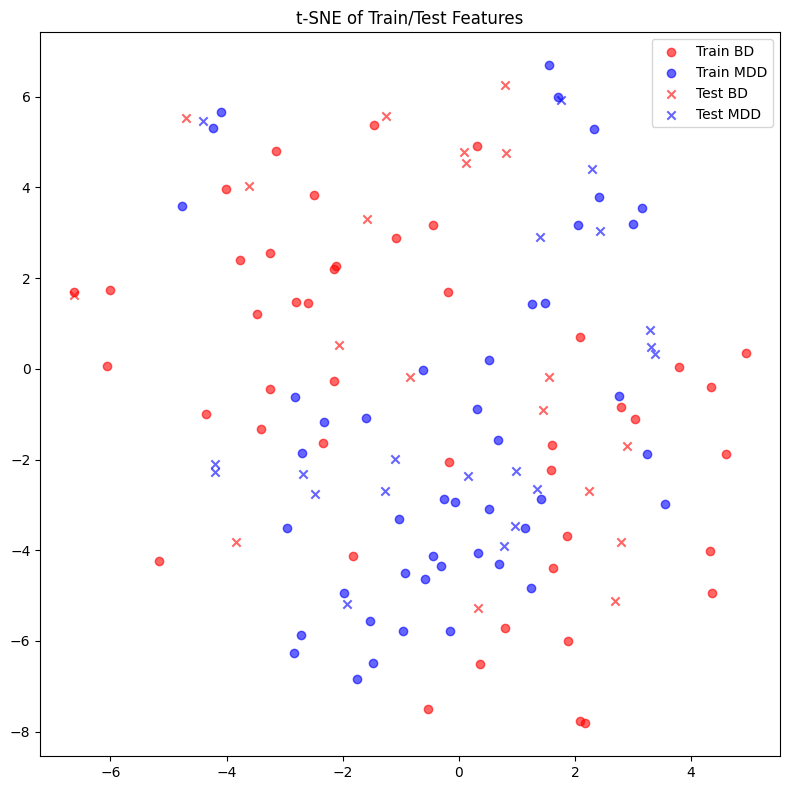

In [7]:
X_tsne = np.array([x.flatten() for x, _ in all_train_raw + all_test_raw])
y_tsne = np.array([y for _, y in all_train_raw + all_test_raw])

set_tsne = np.array([0]*len(all_train_raw) + [1]*len(all_test_raw))  # 0=train, 1=test

print("Running t-SNE on raw features...")

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_tsne)

plt.figure(figsize=(8,8))
masks = {
    'Train BD':  (set_tsne==0)&(y_tsne==0),
    'Train MDD': (set_tsne==0)&(y_tsne==1),
    'Test BD':   (set_tsne==1)&(y_tsne==0),
    'Test MDD':  (set_tsne==1)&(y_tsne==1)
}
markers = {'Train BD':'o','Train MDD':'o','Test BD':'x','Test MDD':'x'}
colors  = {'Train BD':'red','Train MDD':'blue','Test BD':'red','Test MDD':'blue'}

for label,mask in masks.items():
    plt.scatter(X_embedded[mask,0], X_embedded[mask,1],
                marker=markers[label], c=colors[label],
                label=label, alpha=0.6)

plt.legend()
plt.title('t-SNE of Train/Test Features')
plt.tight_layout() 
plt.show()

##### connectivity matrix visualization

Selected subject: E-0118


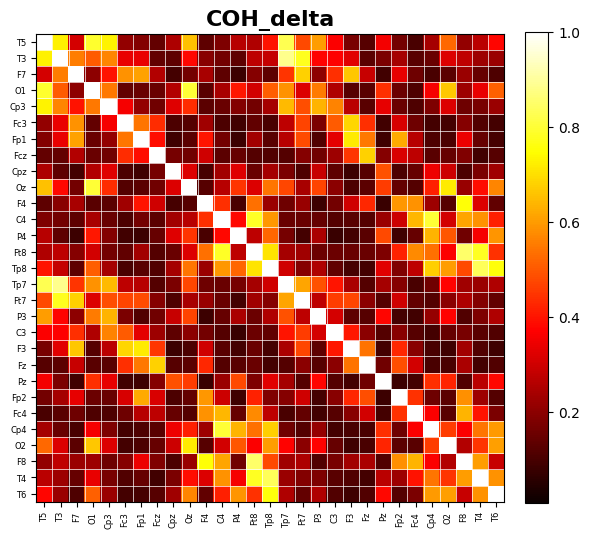

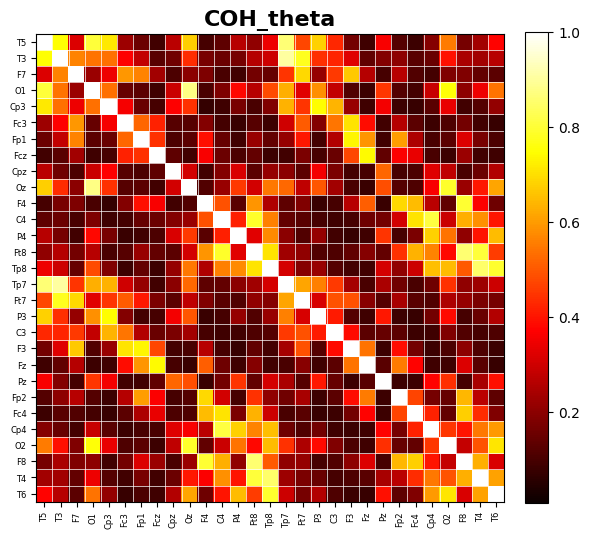

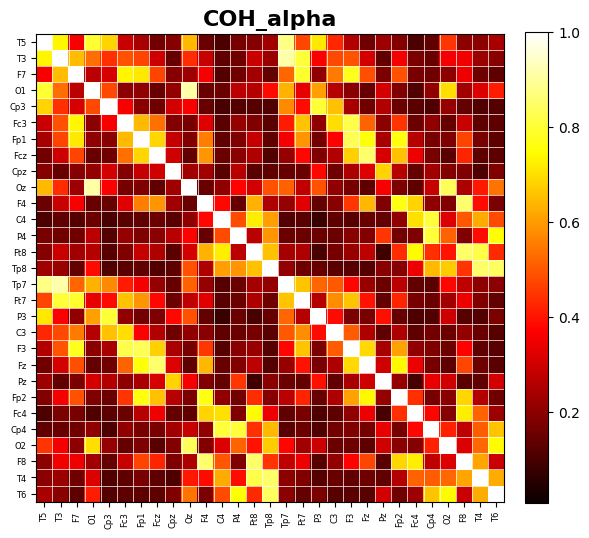

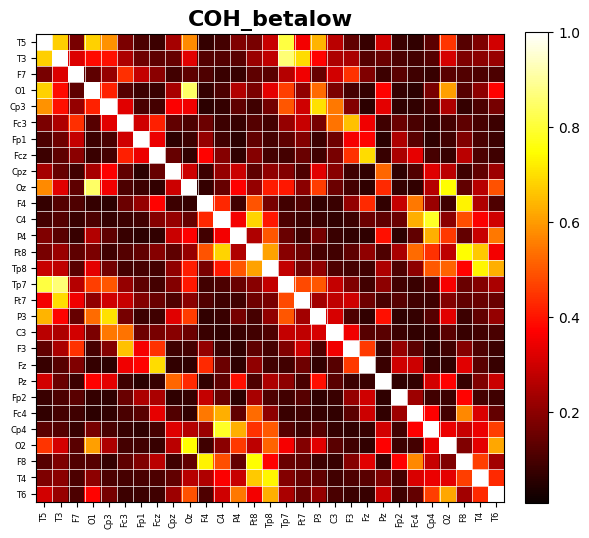

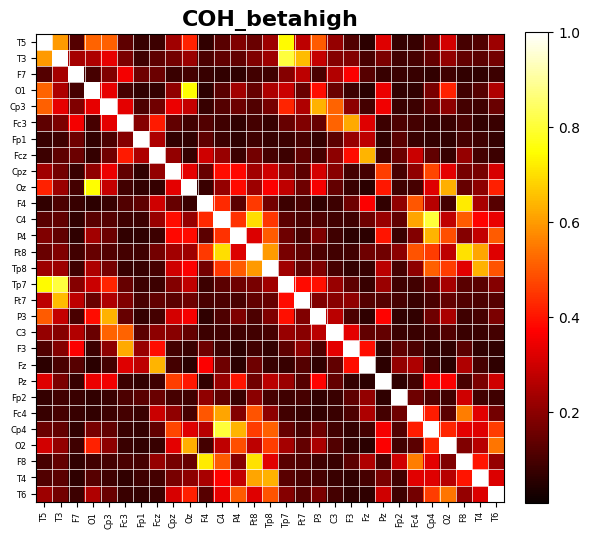

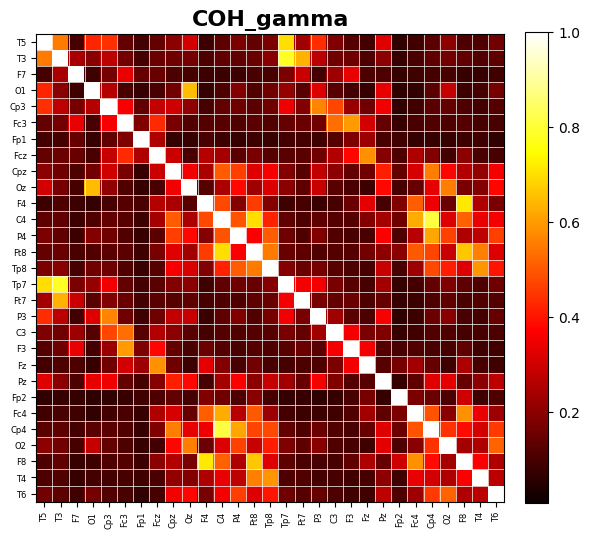

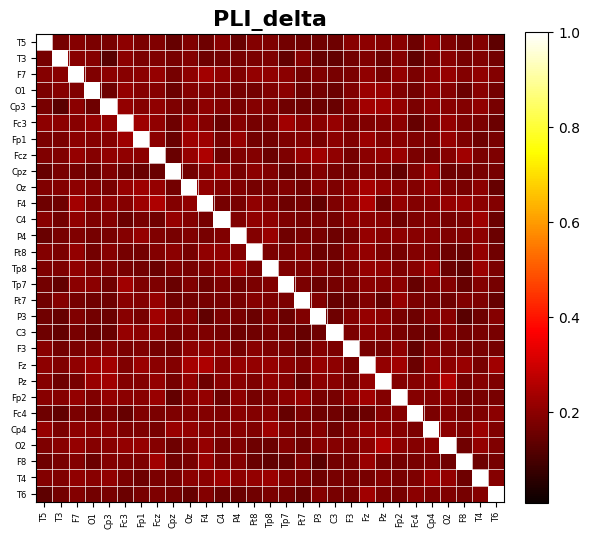

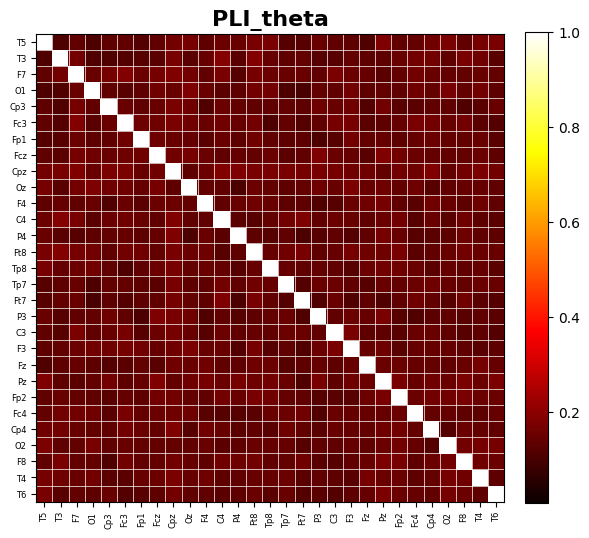

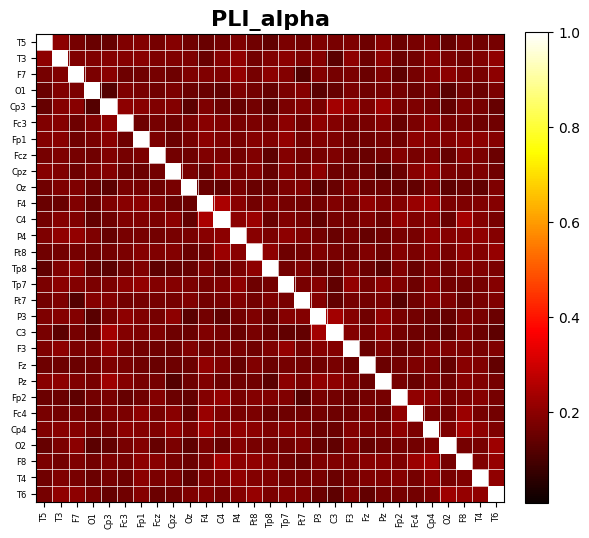

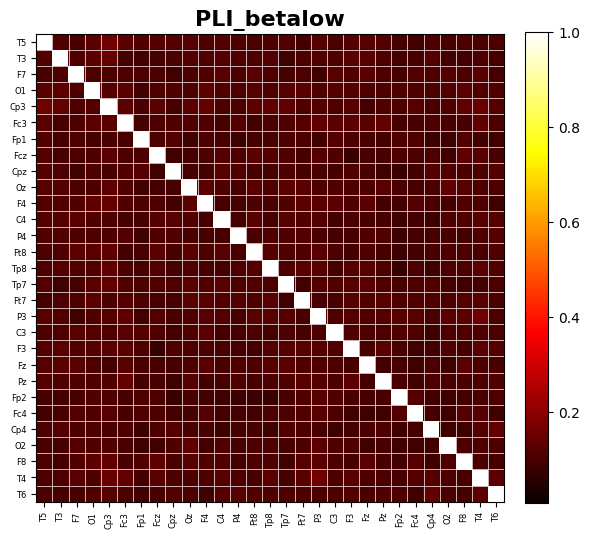

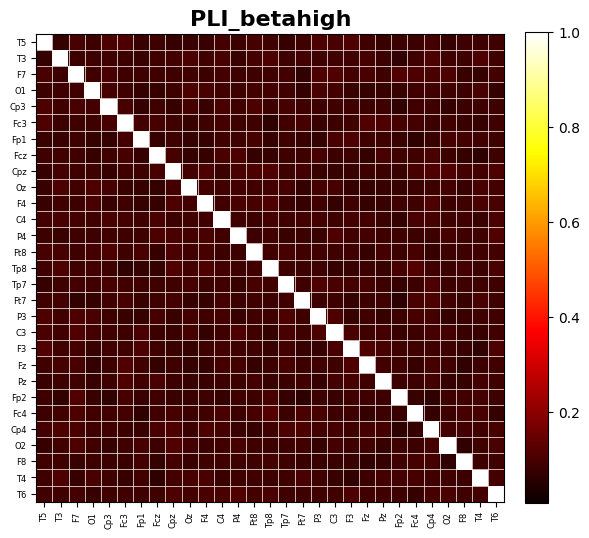

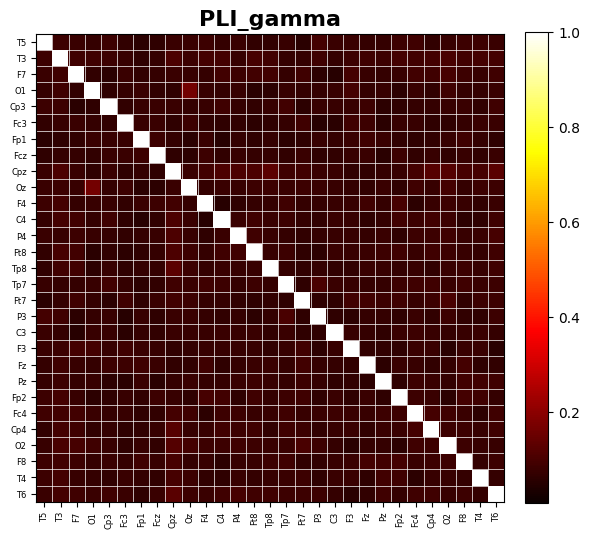

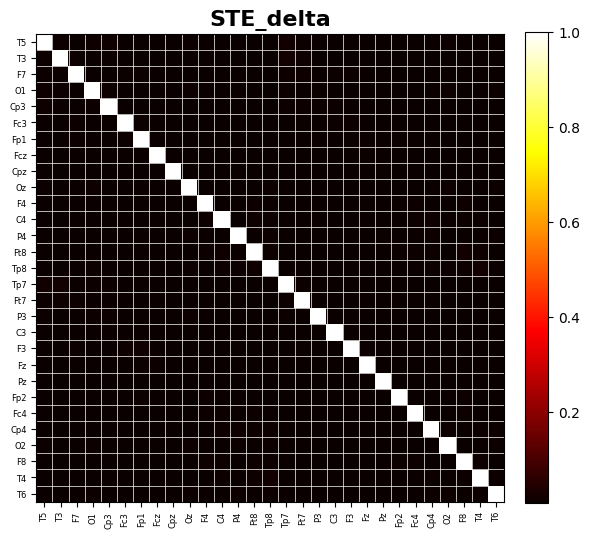

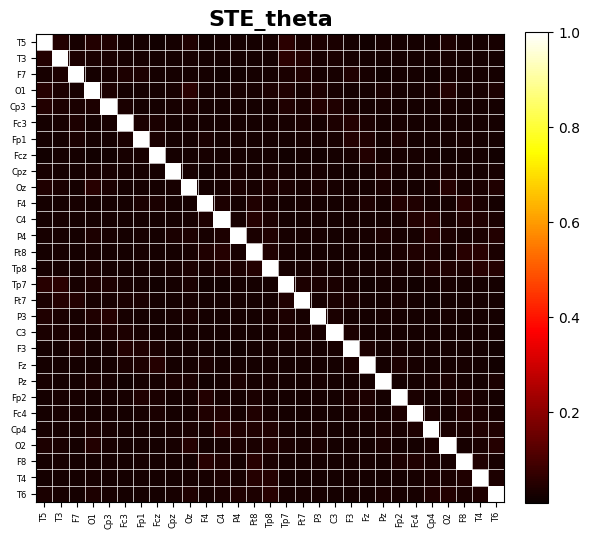

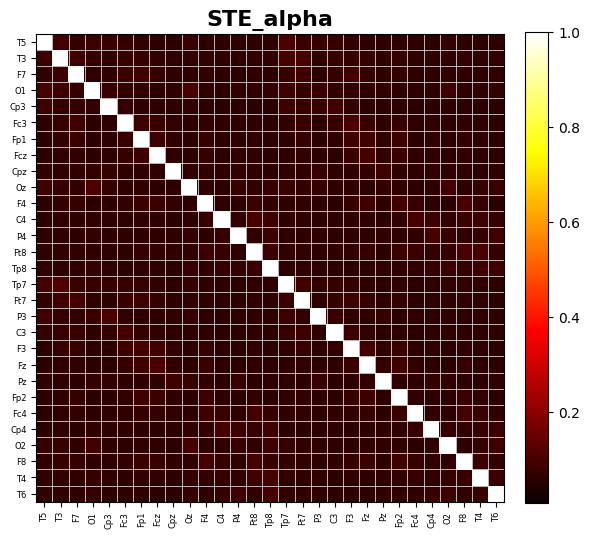

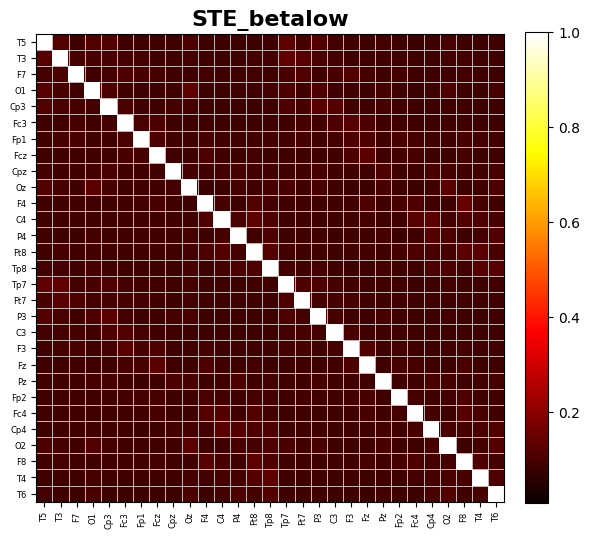

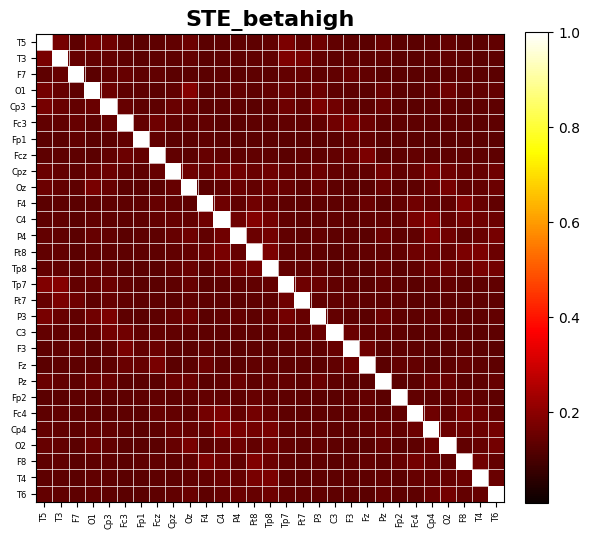

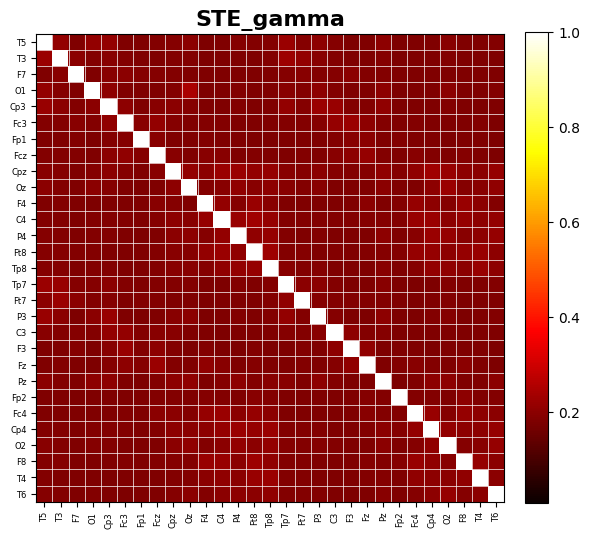

In [8]:
chan_labels = (
    [f"COH_{b}" for b in frequency_bands] +
    [f"PLI_{b}" for b in frequency_bands] +
    [f"STE_{b}" for b in frequency_bands]
)

eloc30_path = "../電極通道/BD_MDD_HC_29_test.loc"
eloc30 = mne.channels.read_custom_montage(eloc30_path)
ch_names = eloc30.ch_names  # list of 29 electrode names


all_subjs = train_bd + train_mdd + test_bd + test_mdd
sel_subj = random.choice(all_subjs)
print(f"Selected subject: {sel_subj}")


if sel_subj in BD_coh:
    tensor = build_subject_tensor(sel_subj, BD_coh, BD_pli, BD_ste)
else:
    tensor = build_subject_tensor(sel_subj, MDD_coh, MDD_pli, MDD_ste)


vmin, vmax = tensor.min(), tensor.max()

for idx in range(18):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(tensor[:, :, idx], cmap='hot',
                   aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(chan_labels[idx], fontsize=16, fontweight='bold')

    ax.set_xticks(np.arange(29)); ax.set_yticks(np.arange(29))
    ax.set_xticklabels(ch_names, fontsize=6, rotation=90)
    ax.set_yticklabels(ch_names, fontsize=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    ax.set_xticks(np.arange(-.5, 29, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 29, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    fig.colorbar(im, ax=ax, orientation='vertical',
                 fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

##### dataloader construction

In [9]:
class EEGDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        X, y = self.data_list[idx]
        #  (channels, H, W)
        X = torch.tensor(X, dtype=torch.float32).permute(2,0,1)
        return X, torch.tensor(y, dtype=torch.long)

def get_train_val_loaders():
    all_train = [
        (build_subject_tensor(s,BD_coh,BD_pli,BD_ste), 0) for s in train_bd
    ] + [
        (build_subject_tensor(s,MDD_coh,MDD_pli,MDD_ste), 1) for s in train_mdd
    ]

    ds = EEGDataset(all_train)
    n_train = int(0.85 * len(ds)) 
    n_val = len(ds) - n_train

    train_ds, val_ds = random_split(ds, [n_train, n_val])
    
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds,   batch_size=batch_size),
        n_train, n_val
    )

test_data   = all_test_raw
test_loader = DataLoader(EEGDataset(test_data), batch_size=batch_size)

##### model design

In [10]:
class EEG_CNN(nn.Module):
    def __init__(self, num_channels=18, num_classes=2):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(512)
        self.pool  = nn.MaxPool2d(2,2)
        # Flatten （512×1×1）
        self._to_linear = 512
        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))); x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x))); x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x))); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [79]:
class EEG_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(18, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, val_loader=None, epochs=20, patience=None):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss, no_improve, best_wts = float('inf'), 0, None
    train_losses, val_losses = [], []

    for epoch in tqdm(range(1, epochs+1), desc="Train", unit="epoch"):

        model.train()
        running = 0
        for Xb,yb in train_loader:
            Xb,yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()*Xb.size(0)
        t_loss = running/len(train_loader.dataset)
        train_losses.append(t_loss)


        if val_loader:
            model.eval() 
            rv=0
            with torch.no_grad():
                for Xv,yv in val_loader:
                    Xv,yv = Xv.to(device), yv.to(device)
                    rv += criterion(model(Xv), yv).item()*Xv.size(0)
            v_loss = rv/len(val_loader.dataset)
            val_losses.append(v_loss)
            cur_loss = v_loss
        else:
            cur_loss = t_loss


        if patience:
            if cur_loss < best_loss:
                best_loss, no_improve = cur_loss, 0
                best_wts = copy.deepcopy(model.state_dict())
            else:
                no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    if best_wts:
        model.load_state_dict(best_wts)
    return train_losses, val_losses
    

##### LOPO-CV

In [17]:
def loocv_predict():
    loo = LeaveOneOut()
    y_true, y_pred = [], []


    epochs = 500
    batch_size = 16
    use_early_stopping = True
    patience = 50   
    use_loocv = True       
    draw_loocv_cm = True 



    for tr_idx, te_idx in loo.split(all_train_raw):

        fold_tr = [all_train_raw[i] for i in tr_idx]
        fold_te = all_train_raw[te_idx[0]]


        full_ds = EEGDataset(fold_tr)
        n_total = len(full_ds)
        n_val   = int(n_total * 0.15)
        n_tr    = n_total - n_val

        train_ds, val_ds = random_split(
            full_ds,
            [n_tr, n_val],
            generator=torch.Generator().manual_seed(42)
        )

        # DataLoader
        tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = EEG_CNN().to(device)


        train_model(
            model,
            tr_loader,
            val_loader,
            epochs=epochs,
            patience=patience if use_early_stopping else None
        )


        model.eval()
        X_te, y_te = fold_te
        X = (torch.tensor(X_te, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device))

        y_true.append(y_te)
        y_pred.append(int(torch.argmax(model(X), dim=1).item()))

    return y_true, y_pred

In [44]:
if use_loocv:
    y_true, y_pred = loocv_predict()
    acc = accuracy_score(y_true, y_pred)
    print(f"LOOCV Accuracy: {acc:.4f}")

Train:  27%|██▋       | 137/500 [00:05<00:15, 23.98epoch/s]


Early stopping at epoch 138


Train:  37%|███▋      | 186/500 [00:07<00:12, 24.54epoch/s]


Early stopping at epoch 187


Train:  41%|████      | 206/500 [00:08<00:12, 24.05epoch/s]


Early stopping at epoch 207


Train:  20%|██        | 101/500 [00:04<00:16, 24.11epoch/s]


Early stopping at epoch 102


Train:  33%|███▎      | 167/500 [00:06<00:13, 24.99epoch/s]


Early stopping at epoch 168


Train:  28%|██▊       | 138/500 [00:05<00:14, 25.16epoch/s]


Early stopping at epoch 139


Train:  25%|██▍       | 124/500 [00:04<00:15, 24.97epoch/s]


Early stopping at epoch 125


Train:  22%|██▏       | 108/500 [00:04<00:15, 25.33epoch/s]


Early stopping at epoch 109


Train:  32%|███▏      | 160/500 [00:06<00:13, 24.96epoch/s]


Early stopping at epoch 161


Train:  28%|██▊       | 141/500 [00:05<00:14, 25.54epoch/s]


Early stopping at epoch 142


Train:  27%|██▋       | 137/500 [00:05<00:13, 26.07epoch/s]


Early stopping at epoch 138


Train:  35%|███▌      | 177/500 [00:07<00:12, 25.19epoch/s]


Early stopping at epoch 178


Train:  24%|██▎       | 118/500 [00:04<00:16, 23.60epoch/s]


Early stopping at epoch 119


Train:  32%|███▏      | 159/500 [00:06<00:14, 24.02epoch/s]


Early stopping at epoch 160


Train:  28%|██▊       | 141/500 [00:05<00:14, 24.76epoch/s]


Early stopping at epoch 142


Train:  29%|██▉       | 145/500 [00:05<00:14, 24.28epoch/s]


Early stopping at epoch 146


Train:  28%|██▊       | 140/500 [00:05<00:14, 24.79epoch/s]


Early stopping at epoch 141


Train:  33%|███▎      | 163/500 [00:06<00:13, 24.79epoch/s]


Early stopping at epoch 164


Train:  41%|████      | 204/500 [00:07<00:11, 26.05epoch/s]


Early stopping at epoch 205


Train:  27%|██▋       | 135/500 [00:05<00:14, 25.51epoch/s]


Early stopping at epoch 136


Train:  34%|███▎      | 168/500 [00:06<00:13, 24.52epoch/s]


Early stopping at epoch 169


Train:  42%|████▏     | 210/500 [00:08<00:11, 25.63epoch/s]


Early stopping at epoch 211


Train:  34%|███▎      | 168/500 [00:06<00:12, 25.76epoch/s]


Early stopping at epoch 169


Train:  40%|████      | 202/500 [00:07<00:11, 25.65epoch/s]


Early stopping at epoch 203


Train:  37%|███▋      | 187/500 [00:07<00:12, 25.71epoch/s]


Early stopping at epoch 188


Train:  41%|████      | 203/500 [00:08<00:12, 24.74epoch/s]


Early stopping at epoch 204


Train:  22%|██▏       | 112/500 [00:04<00:15, 25.29epoch/s]


Early stopping at epoch 113


Train:  38%|███▊      | 192/500 [00:07<00:11, 25.80epoch/s]


Early stopping at epoch 193


Train:  60%|█████▉    | 299/500 [00:11<00:07, 25.90epoch/s]


Early stopping at epoch 300


Train:  39%|███▉      | 195/500 [00:07<00:11, 25.57epoch/s]


Early stopping at epoch 196


Train:  29%|██▉       | 145/500 [00:05<00:13, 25.51epoch/s]


Early stopping at epoch 146


Train:  31%|███       | 153/500 [00:05<00:13, 25.70epoch/s]


Early stopping at epoch 154


Train:  24%|██▎       | 118/500 [00:04<00:14, 25.64epoch/s]


Early stopping at epoch 119


Train:  40%|████      | 200/500 [00:07<00:11, 25.68epoch/s]


Early stopping at epoch 201


Train:  55%|█████▌    | 276/500 [00:10<00:08, 25.85epoch/s]


Early stopping at epoch 277


Train:  37%|███▋      | 186/500 [00:07<00:12, 24.87epoch/s]


Early stopping at epoch 187


Train:  23%|██▎       | 115/500 [00:04<00:15, 24.70epoch/s]


Early stopping at epoch 116


Train:  38%|███▊      | 191/500 [00:07<00:12, 25.08epoch/s]


Early stopping at epoch 192


Train:  34%|███▍      | 169/500 [00:06<00:13, 24.92epoch/s]


Early stopping at epoch 170


Train:  26%|██▌       | 131/500 [00:05<00:14, 25.37epoch/s]


Early stopping at epoch 132


Train:  25%|██▌       | 125/500 [00:04<00:14, 25.18epoch/s]


Early stopping at epoch 126


Train:  31%|███▏      | 157/500 [00:06<00:13, 25.80epoch/s]


Early stopping at epoch 158


Train:  39%|███▊      | 193/500 [00:07<00:12, 25.47epoch/s]


Early stopping at epoch 194


Train:  31%|███▏      | 157/500 [00:06<00:13, 25.13epoch/s]


Early stopping at epoch 158


Train:  31%|███       | 153/500 [00:06<00:13, 25.14epoch/s]


Early stopping at epoch 154


Train:  31%|███▏      | 157/500 [00:06<00:13, 25.12epoch/s]


Early stopping at epoch 158


Train:  20%|██        | 102/500 [00:03<00:15, 25.59epoch/s]


Early stopping at epoch 103


Train:  24%|██▍       | 120/500 [00:04<00:14, 25.74epoch/s]


Early stopping at epoch 121


Train:  21%|██        | 104/500 [00:04<00:15, 24.75epoch/s]


Early stopping at epoch 105


Train:  26%|██▋       | 132/500 [00:05<00:14, 25.11epoch/s]


Early stopping at epoch 133


Train:  28%|██▊       | 140/500 [00:05<00:14, 25.27epoch/s]


Early stopping at epoch 141


Train:  29%|██▊       | 143/500 [00:05<00:14, 25.24epoch/s]


Early stopping at epoch 144


Train:  25%|██▌       | 127/500 [00:05<00:14, 25.14epoch/s]


Early stopping at epoch 128


Train:  26%|██▋       | 132/500 [00:05<00:14, 24.81epoch/s]


Early stopping at epoch 133


Train:  22%|██▏       | 108/500 [00:04<00:17, 22.21epoch/s]


Early stopping at epoch 109


Train:  34%|███▎      | 168/500 [00:06<00:12, 25.85epoch/s]


Early stopping at epoch 169


Train:  22%|██▏       | 109/500 [00:04<00:15, 25.65epoch/s]


Early stopping at epoch 110


Train:  32%|███▏      | 159/500 [00:06<00:13, 24.99epoch/s]


Early stopping at epoch 160


Train:  33%|███▎      | 165/500 [00:06<00:12, 25.94epoch/s]


Early stopping at epoch 166


Train:  25%|██▌       | 127/500 [00:04<00:14, 25.51epoch/s]


Early stopping at epoch 128


Train:  18%|█▊        | 92/500 [00:03<00:16, 24.72epoch/s]


Early stopping at epoch 93


Train:  25%|██▌       | 125/500 [00:04<00:14, 25.44epoch/s]


Early stopping at epoch 126


Train:  26%|██▌       | 128/500 [00:05<00:14, 25.09epoch/s]


Early stopping at epoch 129


Train:  28%|██▊       | 138/500 [00:05<00:14, 25.00epoch/s]


Early stopping at epoch 139


Train:  23%|██▎       | 113/500 [00:04<00:15, 24.63epoch/s]


Early stopping at epoch 114


Train:  25%|██▌       | 127/500 [00:05<00:15, 23.78epoch/s]


Early stopping at epoch 128


Train:  22%|██▏       | 108/500 [00:04<00:15, 25.55epoch/s]


Early stopping at epoch 109


Train:  21%|██        | 104/500 [00:04<00:16, 24.72epoch/s]


Early stopping at epoch 105


Train:  32%|███▏      | 162/500 [00:06<00:13, 24.43epoch/s]


Early stopping at epoch 163


Train:  33%|███▎      | 165/500 [00:06<00:13, 25.20epoch/s]


Early stopping at epoch 166


Train:  24%|██▍       | 120/500 [00:04<00:15, 24.25epoch/s]


Early stopping at epoch 121


Train:  25%|██▌       | 126/500 [00:04<00:14, 25.33epoch/s]


Early stopping at epoch 127


Train:  25%|██▌       | 126/500 [00:05<00:15, 24.78epoch/s]


Early stopping at epoch 127


Train:  33%|███▎      | 165/500 [00:06<00:13, 25.32epoch/s]


Early stopping at epoch 166


Train:  21%|██▏       | 107/500 [00:04<00:16, 23.95epoch/s]


Early stopping at epoch 108


Train:  26%|██▌       | 128/500 [00:05<00:15, 24.74epoch/s]


Early stopping at epoch 129


Train:  22%|██▏       | 109/500 [00:04<00:16, 24.38epoch/s]


Early stopping at epoch 110


Train:  29%|██▉       | 144/500 [00:05<00:14, 25.25epoch/s]


Early stopping at epoch 145


Train:  22%|██▏       | 108/500 [00:04<00:15, 25.46epoch/s]


Early stopping at epoch 109


Train:  30%|██▉       | 149/500 [00:05<00:13, 25.48epoch/s]


Early stopping at epoch 150


Train:  53%|█████▎    | 265/500 [00:10<00:09, 25.53epoch/s]


Early stopping at epoch 266


Train:  33%|███▎      | 164/500 [00:06<00:13, 25.25epoch/s]


Early stopping at epoch 165


Train:  43%|████▎     | 215/500 [00:08<00:11, 25.34epoch/s]


Early stopping at epoch 216


Train:  26%|██▌       | 131/500 [00:06<00:16, 21.79epoch/s]


Early stopping at epoch 132


Train:  21%|██▏       | 107/500 [00:04<00:15, 25.56epoch/s]


Early stopping at epoch 108


Train:  22%|██▏       | 111/500 [00:04<00:15, 24.53epoch/s]


Early stopping at epoch 112


Train:  27%|██▋       | 137/500 [00:05<00:14, 25.18epoch/s]


Early stopping at epoch 138


Train:  22%|██▏       | 108/500 [00:04<00:15, 25.01epoch/s]


Early stopping at epoch 109


Train:  27%|██▋       | 134/500 [00:05<00:14, 24.66epoch/s]


Early stopping at epoch 135


Train:  24%|██▍       | 120/500 [00:04<00:15, 25.02epoch/s]

Early stopping at epoch 121
LOOCV Accuracy: 0.8000


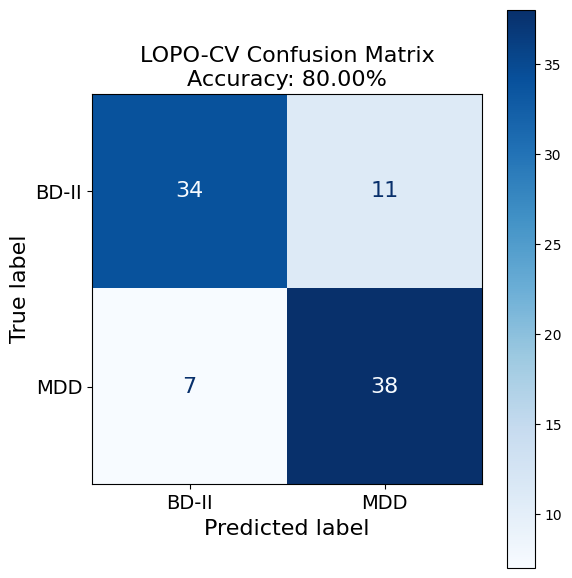

In [ ]:
if draw_loocv_cm:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["BD-II", "MDD"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)

    lopoacc = acc * 100

    ax.set_title(f"LOPO-CV Confusion Matrix\nAccuracy: {lopoacc:.2f}%", fontsize=16)

    ax.tick_params(axis='both', labelsize=14)

    for txt in ax.texts:
        txt.set_fontsize(16)

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.tight_layout()
    # plt.savefig("../result_DL/BD_MDD/wo_DA/LOPO-CV_Confusion_Matrix.png", dpi=300)
    plt.show()

##### train whole dataset

In [60]:
train_loader, val_loader, n_train, n_val = get_train_val_loaders()
model = EEG_CNN().to(device)
train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    epochs=epochs,
    patience=patience if use_early_stopping else None
)

Train:  46%|████▌     | 229/500 [00:09<00:10, 25.08epoch/s]

Early stopping at epoch 230


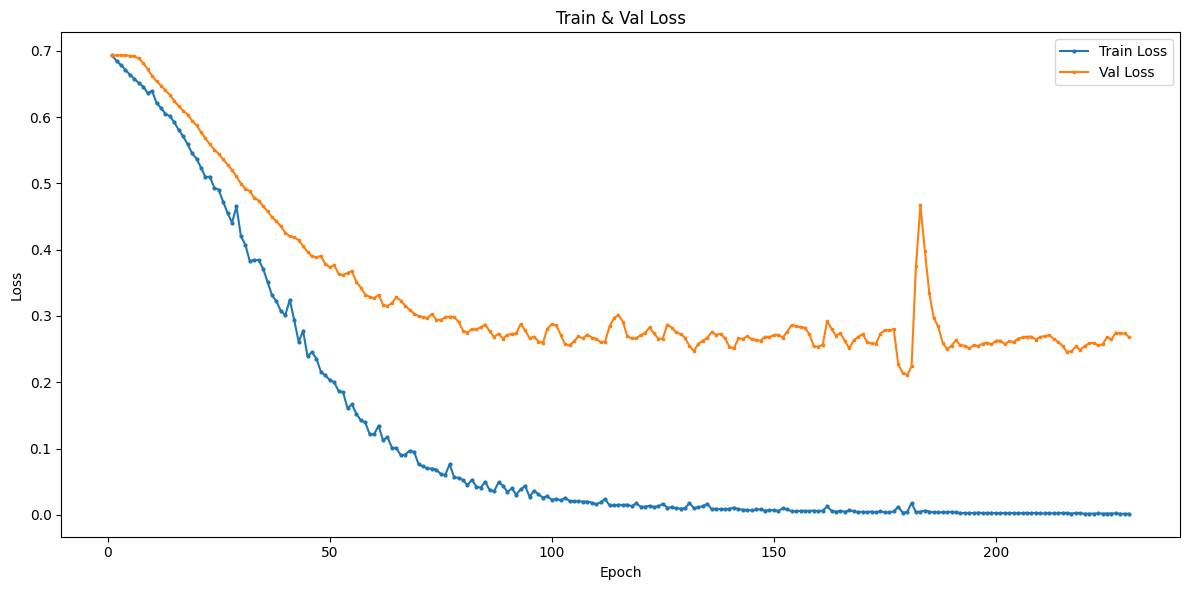

In [61]:
plt.figure(figsize=(12,6))
plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train Loss', markersize=2)
plt.plot(range(1,len(val_losses)+1),   val_losses,   marker='s', label='Val Loss', markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Val Loss') 
plt.legend()
plt.tight_layout()
plt.show()

##### save model

In [34]:
model_save = model.state_dict()
with open("../result_DL/BD_MDD/wo_DA/classification_model/cnn_final_model_complex.pt", "wb") as f:
    torch.save(model_save, f)

##### load model

In [48]:
model = EEG_CNN().to(device)
checkpoint = torch.load(
    "../result_DL/BD_MDD/wo_DA/classification_model/cnn_final_model_complex.pt",
    map_location=torch.device('cpu')
)
model.load_state_dict(checkpoint)
model.eval()

C:\Users\NESS-Kuan\AppData\Local\Temp\ipykernel_25244\725220334.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


EEG_CNN(
  (conv1): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, b

##### independent test

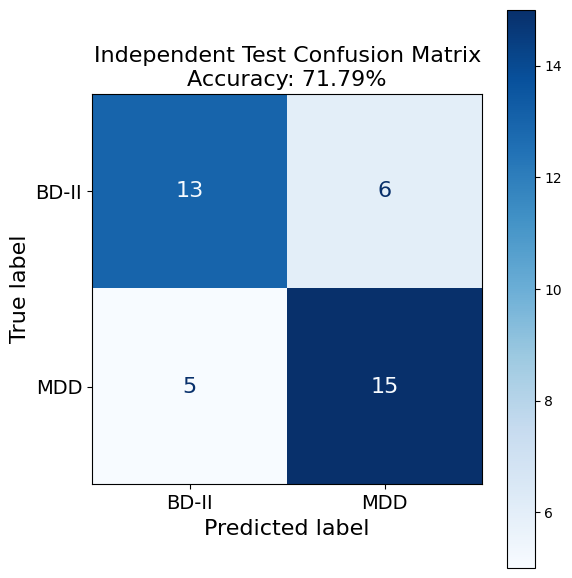

In [62]:
model.eval()
preds, labels = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds.extend(torch.argmax(model(Xb), dim=1).cpu().numpy())
        labels.extend(yb.numpy())

test_acc = accuracy_score(labels, preds) * 100

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["BD-II", "MDD"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)


ax.set_title(f"Independent Test Confusion Matrix\nAccuracy: {test_acc:.2f}%", fontsize=16)

ax.tick_params(axis='both', labelsize=14)

for txt in ax.texts:
    txt.set_fontsize(16)

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)

plt.tight_layout()
# plt.savefig("../result_DL/BD_MDD/wo_DA/Independent_Test_Confusion_Matrix.png", dpi=300)
plt.show()

